In [ ]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering as agg
from sklearn.metrics import silhouette_score, davies_bouldin_score
from scipy.spatial.distance import pdist
from sklearn.metrics import adjusted_rand_score as ari
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from joblib import Parallel, delayed
import time
np.random.seed(42)

In [2]:
gene_feats = pd.read_csv("ClusterDataset.csv")
gene_feats.head()

,Name,ENSG00000244734.3,ENSG00000210082.2,ENSG00000198804.2,ENSG00000198712.1,ENSG00000198938.2,ENSG00000188536.12,ENSG00000198899.2,ENSG00000198886.2,ENSG00000275896.5,...,ENSG00000176749.8,ENSG00000241973.10,ENSG00000118689.14,ENSG00000167680.15,ENSG00000148053.15,ENSG00000134291.11,ENSG00000183578.6,ENSG00000164091.11,ENSG00000173418.11,tissue
0,GTEX-1117F-0226-SM-5GZZ7,452.7,6310.0,10790.0,11720.0,19890.0,102.40,13880.0,12400.0,0.000,...,2.0290,31.85,62.17,24.530,18.2900,17.720,45.8000,76.38,61.47,Adipose Tissue
1,GTEX-1117F-0426-SM-5EGHI,225.7,10200.0,33610.0,37500.0,62560.0,52.01,51690.0,34030.0,46.660,...,1.6640,14.18,110.90,9.736,0.2841,8.708,0.7015,44.89,80.30,Muscle
2,GTEX-1117F-0526-SM-5EGHJ,269.6,6111.0,9689.0,12250.0,19450.0,62.95,16270.0,13820.0,159.200,...,1.6410,30.01,73.15,33.440,16.6400,33.610,77.1700,62.28,46.12,Blood Vessel
3,GTEX-1117F-0626-SM-5N9CS,5272.0,11990.0,4269.0,10630.0,16440.0,1323.00,16350.0,11990.0,3.747,...,1.8950,39.19,60.41,29.950,21.3700,58.980,38.1100,74.41,51.21,Blood Vessel
4,GTEX-1117F-0726-SM-5GIEN,1617.0,40440.0,56700.0,39220.0,64660.0,403.50,82550.0,69350.0,9.192,...,0.6289,15.62,20.16,14.000,4.5110,23.490,5.6750,31.22,22.02,Heart


In [ ]:
#Get labels
labels = gene_feats["tissue"].to_list()
#Remove gene column and features column convert to numpy array
gene_array = gene_feats.iloc[:,1:-1].to_numpy()
norm_genes = StandardScaler().fit_transform(gene_array)


## Cluster Analysis

### Compare metrics and Kmeans and Agglomerative with External Metrics

Use External metrics Ari and NMI to evaluate how Kmeans and Agglomerative clustering compare on a few different parameter settings

### Test KMeans

1. Try different algorithms and compare to ground truth using ARI and NMI and test speed

In [ ]:

alg = ['lloyd', 'elkan']

def Test_kmean(a):

    km = KMeans(n_clusters=10, n_init="auto", random_state=0,algorithm=a)
    start = time.time()
    labels_km = km.fit_predict(norm_genes)   
    stop = time.time()

    ari = adjusted_rand_score(labels, labels_km)
    nmi = normalized_mutual_info_score(labels, labels_km)
    
    Run_time = stop-start

    return a,ari,nmi,Run_time
results = Parallel(n_jobs=2)(delayed(Test_kmean)(a) for a in alg)
results

[('lloyd', 0.34875374185373864, 0.587985443690967, 8.167040348052979),
 ('elkan', 0.34875374185373864, 0.587985443690967, 7.7848780155181885)]

Algorithm Complexity is close to

$O(n)$

Using fixed number of clusters

Results of kmeans algo comparison:

$
\begin{array}{lccc}
\text{Algorithm} & \text{ARI} & \text{NMI} & \text{Runtime (s)} \\
\hline
\text{lloyd} & 0.3488 & 0.5880 & 8.17 \\
\text{elkan} & 0.3488 & 0.5880 & 7.78 \\
\end{array}
$



Algorithm comparison: Lloyd and Elkan result in the same Ari and NMI scores for cluster of 10 against the ground truth labels. The elkan algorithm is slightly faster

### Test AgglomerativeClustering

1. Use PCA to reduce dimensions test several different dimensions

Algorithm complexity:

$O(n^2)$

2. Investigate different linkage strategies

In [8]:
linkage = ['single','average','complete','ward']

def Test_Agg(l):

    m = agg(n_clusters=10, linkage=l)
    start = time.time()
    labels_m = m.fit_predict(genes_PCA)   
    stop = time.time()

    ari = adjusted_rand_score(labels, labels_m)
    nmi = normalized_mutual_info_score(labels, labels_m)
    
    Run_time = stop-start

    return l,ari,nmi,Run_time

#Test 30, 50, 60 components
c =[30,50,70]
Runs={}
for i in c:
    pca = PCA(n_components=i,random_state=42)
    genes_PCA = pca.fit_transform(norm_genes)

    results = Parallel(n_jobs=4)(delayed(Test_Agg)(l) for l in linkage)
    Runs[i]=results
    print(i,results)

30 [('single', 0.0047112124170275, 0.02811896719576749, 6.361384630203247), ('average', 0.014829726316789447, 0.21824384441681038, 33.05629920959473), ('complete', -0.012678784136830256, 0.15174726392295992, 29.052094221115112), ('ward', 0.26869253974574425, 0.5727292276734507, 28.65898871421814)]
50 [('single', 0.014156753675706235, 0.08511234885117307, 9.662238836288452), ('average', -0.01568556922030629, 0.06225052160229908, 37.79436683654785), ('complete', -0.0038231206847636145, 0.12501699184147755, 39.70138478279114), ('ward', 0.3347578915498997, 0.5897405201080803, 39.45761823654175)]
70 [('single', 0.004627425810447109, 0.028028184258731943, 11.22221827507019), ('average', -0.006638615519872049, 0.10304548626491376, 22.25364851951599), ('complete', -0.0038433355696942707, 0.13003679072981614, 20.932704210281372), ('ward', 0.28706448493142966, 0.5836407927189812, 21.91947865486145)]


### Results Agglomerative with PCA reduction

$
\text{PCA 30 Components}\\[4pt]
\begin{array}{lccc}
\text{Linkage} & \text{ARI} & \text{NMI} & \text{Runtime (s)} \\
\hline
\text{single}   & 0.0047  & 0.0281 & 6.36 \\
\text{average}  & 0.0148  & 0.2182 & 33.06 \\
\text{complete} & -0.0127 & 0.1517 & 29.05 \\
\text{ward}     & 0.2687  & 0.5727 & 28.65 \\
\end{array}
$


$
\text{PCA 50 Components}\\[4pt]
\begin{array}{lccc}
\text{Linkage} & \text{ARI} & \text{NMI} & \text{Runtime (s)} \\
\hline
\text{single}   & 0.0142  & 0.0851 & 9.66 \\
\text{average}  & -0.0157 & 0.0623 & 37.79 \\
\text{complete} & -0.0038 & 0.1250 & 39.7 \\
\text{ward}     & 0.3348  & 0.5897 & 39.45 \\
\end{array}
$

$
\text{PCA 70 Components}\\[4pt]
\begin{array}{lccc}
\text{Linkage} & \text{ARI} & \text{NMI} & \text{Runtime (s)} \\
\hline
\text{single}   & 0.0046  & 0.0280 & 11.22 \\
\text{average}  & -0.0066 & 0.1030 & 22.25 \\
\text{complete} & -0.0038 & 0.1300 & 20.90 \\
\text{ward}     & 0.2871  & 0.5836 & 21.91 \\
\end{array}
$

Highest performance at a PCA cluster of 50 components

Single is the fastest linkage method - this makes sense because agglomerative first treats each point as its own cluster, it then merges closest clusters and updates distances as they merge. Single linkage uses the minimum distance between two points for the update which is not super computationally heavy.

Complete is the slowest which makes sense because it uses the maximum distance between all observations

Ward is slower than single because it minimizes the vairance of the clusters being merged.
It also gives the best clustering based on ARI and NMI

### KMeans Vs. Agglomerative

Kmeans is twice as fast with equivalent performance as the best PCA 50 Ward linkage agglomerative clustering model

Conclusion: Using the same known number of components as tissues (10), the best clustering performance between the two clustering methods peaks (for the parameters tested) at an NMI of ~0.588. 

This means I am capturing a reasonable amount of signal for the 10 tissues based on the top 5000 highest variance genes. 



## Use Internal Metrics 

### KMeans internal metrics

In [ ]:
def Test_kmean(c,runs):
    all_labels=[]
    for i in runs:
        km = KMeans(n_clusters=c, n_init="auto", random_state=i,algorithm='elkan')
        labels_km = km.fit_predict(norm_genes)   
        all_labels.append(labels_km)
    ari_dist = pdist(all_labels,metric=ari)
    
    return pd.DataFrame({"clusters": [c] * len(ari_dist),"ari_stability": ari_dist,})
    

clusters=range(2,14,2) #create only even clusters for speed
runs=range(5)
ARI_results = Parallel(n_jobs=16)(delayed(Test_kmean)(c,runs) for c in clusters)
stability_df = pd.concat(ARI_results, ignore_index=True)

Text(0.5, 1.0, 'Ari Stability Vs. Clusters')

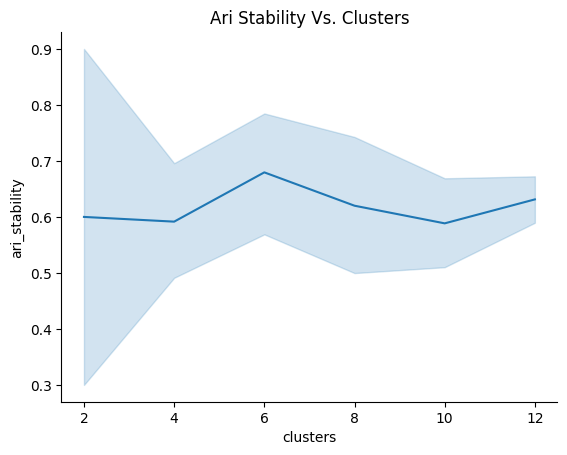

In [19]:
import matplotlib.pyplot as plt
sns.lineplot(data=stability_df, x="clusters", y="ari_stability")
sns.despine()
plt.title("Ari Stability Vs. Clusters")

#### Interpretation

Lower cluster values have decreased clustering stability as represented by the variance in the stability score.

As the number of clusters increases there is more stability in clustering. 

There is nothing notable about 10 clusters specifically. Even though this is the number of tissues we have that does not mean there are necessarily 10 gene clusters. It is possible a different number of clusters better represents that actual genetic data.

#### NOTE Agglomerate is deterministic so would have to add random noise for comparison 

Only showing Kmeans because of this

In [ ]:
def Test_kmean(c,runs):
    silhouettes = []
    bouldins = []
    for i in range(runs):
        km = KMeans(n_clusters=c, n_init="auto", random_state=i,algorithm='elkan')
        labels_km = km.fit_predict(norm_genes)   
        
        silhouettes.append(silhouette_score(norm_genes,labels_km))
        bouldins.append(davies_bouldin_score(norm_genes, labels_km))
    
    return pd.DataFrame({"clusters": [c] * runs,"silhouette": silhouettes,"bouldin":bouldins})

clusters=range(2,14,2) #create only even clusters for speed
runs=5
internal_results = Parallel(n_jobs=16)(delayed(Test_kmean)(c,runs) for c in clusters)

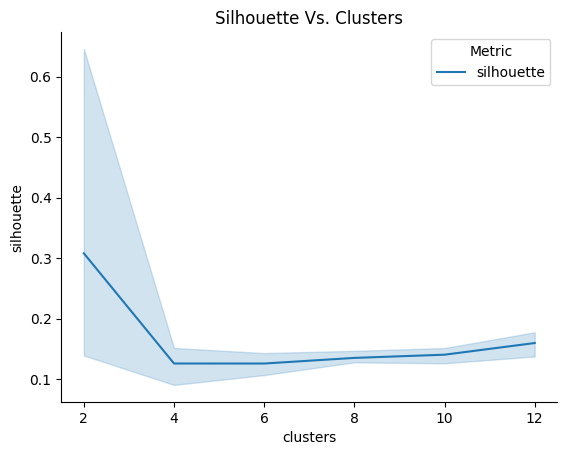

In [22]:
internal_df = pd.concat(internal_results, ignore_index=True)
sns.lineplot(data=internal_df, x="clusters", y="silhouette",label="silhouette")
sns.despine()
plt.title("Silhouette Vs. Clusters")
plt.legend(title="Metric")

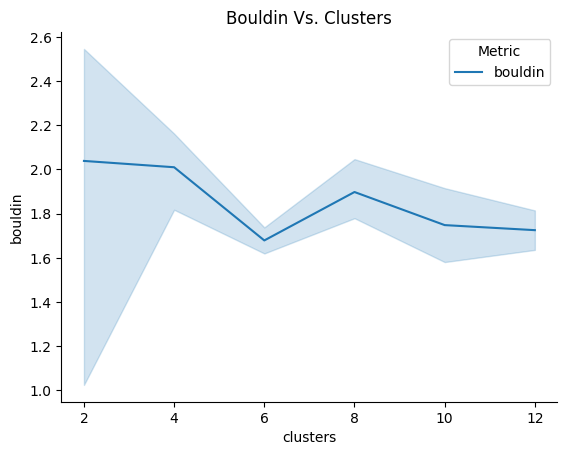

In [21]:
sns.lineplot(data=internal_df, x="clusters", y="bouldin",label="bouldin")
sns.despine()
plt.title("Bouldin Vs. Clusters")
plt.legend(title="Metric")

### Interpretation of Silouhette and Bouldin Scores

If clusters were tight and spread out, we would expect a higher Silouhette and a lower Bouldin. The best cluster would be at the maximum of silouhette and the minimum of Bouldin.

There is not a clear maximum or a clear miminum for either of these scores across even clusters from 2 to 14. 

All this means is each cluster gives a similar level of compactness and separation of the points. Internal metrics do not define any one best k (such as 10, the number of tissues).

